When thinking of features to use for our Naive Bayes classifier, we thought that co-occurrences and plmi scores could be useful to use as features, since polar words such as "great" or "terrible" often co-occur with nouns in reviews.

I first found the most common co-occurrences per class. We then looked at the most polarized (aka with the highest combined positive and negative SentiWordNet scores) co-occurrences per class, using the polarity as weights for the co-occurrences. Finally, we looked at PLMI scores per class as well as average positivity and negativity (based on summed SentiWordNet values) per class. Lanie coded these functions in this notebook, which Floor then adapted for use with a Naive Bayes classifier in her Machine Learning notebooks.


We also thought that finding the co-occurrences of nouns in the review with negative or positive words from the corpus would be a good way to find out exactly which parts of the purchased product make it good or bad. For example, in a hot sauce review, it would be helpful for manufacturers and consumers alike to understand if it's the flavor, packaging, or something else that make it popular or unpopular. 

In [3]:
import nltk
import pickle
import random

with open('training_dicts.txt', 'rb') as file:
    lemmedreviews = pickle.load(file)
    
#make lists for each class in training set 
one_star = lemmedreviews[1]
two_star = lemmedreviews[2]
three_star = lemmedreviews[3]
four_star = lemmedreviews[4]
five_star = lemmedreviews[5]

# Find Basic Co-Occurrences #

In [4]:
#find basic co-occurrences in each class 
from collections import Counter

def find_cooccs(lst):
    span = 3
    cooccs_stem_surface = Counter()

    for sentence in lst:
        for i,w in enumerate(sentence):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(sentence)))) 
            for cw in [sentence[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_stem_surface:
                    cooccs_stem_surface[(w, cw)] += 1
    
    print(cooccs_stem_surface.most_common(10))
    return cooccs_stem_surface 

#apply to every class 
one_cooccs = find_cooccs(one_star)
two_cooccs = find_cooccs(two_star)
three_cooccs = find_cooccs(three_star)
four_cooccs = find_cooccs(four_star)
five_cooccs = find_cooccs(five_star)

[(('taste-NOUN', 'like-ADP'), 90), (('would-VERB', 'not-NEGATION'), 58), (('not-NEGATION', 'product-NOUN'), 58), (('like-ADP', 'not-NEGATION'), 58), (('taste-NOUN', 'not-NEGATION'), 51), (('not-NEGATION', 'even-ADV'), 39), (('not-NEGATION', 'buy-VERB'), 36), (('not-NEGATION', 'say-VERB'), 27), (('not-NEGATION', 'good-ADJ'), 26), (('one-NUM', 'not-NEGATION'), 25)]
[(('like-ADP', 'taste-NOUN'), 63), (('like-ADP', 'not-NEGATION'), 58), (('not-NEGATION', 'taste-NOUN'), 50), (('coffee-NOUN', 'like-ADP'), 37), (('would-VERB', 'not-NEGATION'), 36), (('not-NEGATION', 'good-ADJ'), 34), (('not-NEGATION', 'product-NOUN'), 27), (('really-ADV', 'like-ADP'), 24), (('not-NEGATION', 'try-VERB'), 22), (('not-NEGATION', 'much-ADJ'), 22)]
[(('taste-NOUN', 'like-ADP'), 86), (('not-NEGATION', 'would-VERB'), 75), (('taste-NOUN', 'not-NEGATION'), 68), (('not-NEGATION', 'like-ADP'), 64), (('good-ADJ', 'not-NEGATION'), 56), (('coffee-NOUN', 'not-NEGATION'), 56), (('not-NEGATION', 'really-ADV'), 48), (('one-NUM

# Sort Co-Occurrences by their Polarity # 

We found fewer patterns than expected in the basic co-occurrences, so I decided to find the polarity of each word in the tuple using SentiWordNet, summing the positive and negative values of both words, and storing the tuple in its value in a list before sorting it. These cooccs were more informative than the cooccs that were just sorted based on their raw frequencies in the data   

In [5]:
#perform sentiment analysis
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn 
import operator 
import collections

#create mapping for proper sentiment analysis 
mapping = {'NOUN':wn.NOUN, "ADJ": wn.ADJ, 'VERB' : wn.VERB, "ADV": wn.ADV}

def find_vals(lst):
    #make synsets out of tuples
    list_cooccs = lst
    word1, word2 = "", ""
    positive_score, negative_score, positive_score2, negative_score2 = 0,0,0,0
    #dictionary to store tuples of co-occurences and their positivity 
    wordvals = {}

    #give items new mapping for use with senti_synsets
    for tup in list_cooccs:
        #get individual words out of tuple
        w1 = tup[0].split("-")
        w2 = tup[1].split("-")
    
        #check if first word in tuple is contained within mapping
        if w1[1] in mapping.keys() and mapping[w1[1]] == 'a':
            #extract part of speech
            one_pos = mapping[w1[1]]
            #extract the word itself 
            word1 = w1[0]
        
            #test that synsets exist 
            if len(list(swn.senti_synsets(word1, pos = one_pos))) > 0:
                scores = swn.senti_synset(word1 + "."+ one_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score = scores.pos_score()
                negative_score = scores.neg_score()
            
        #repeat for second word in tuple         
        if w2[1] in mapping.keys() and mapping[w2[1]] == 'n':
            #extract part of speech 
            two_pos = mapping[w2[1]]
            word2 = w2[0]
        
            if len(list(swn.senti_synsets(word2, pos = two_pos))) > 0:
                scores2 = swn.senti_synset(word2 + "."+ two_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score2 = scores2.pos_score()
                negative_score2 = scores2.neg_score() 
            
        #store tuples and positivity values in a dictionary
        tupl = (word1, word2)
        wordvals[tupl] = (positive_score + negative_score + positive_score2 + negative_score2)

    #sort the dictionary of positive and negative values from largest to smallest 
    sorted_wordvals = list(reversed(sorted(wordvals.items(), key=operator.itemgetter(1))))
    #sorted_dict = collections.OrderedDict(reversed(sorted_wordvals))
    return sorted_wordvals

one_vals = find_vals(one_cooccs)
two_vals = find_vals(two_cooccs)
three_vals = find_vals(three_cooccs)
four_vals = find_vals(four_cooccs)
five_vals = find_vals(five_cooccs)


In [6]:
print(one_vals[10:20])
print(two_vals[10:20])
print(three_vals[10:20])
print(four_vals[10:20])
print(five_vals[10:20])

[(('hard', 'aka'), 1.625), (('hard', 'hink'), 1.625), (('poor', 'mistake'), 1.625), (('different', 'difference'), 1.5), (('different', 'explain'), 1.5), (('bold', 'reserve'), 1.5), (('nasty', 'fake'), 1.5), (('negative', 'avoid'), 1.5), (('negative', 'health'), 1.5), (('nice', 'love'), 1.5)]
[(('nice', 'health'), 1.5), (('weigh', 'asset'), 1.5), (('poor', 'drawback'), 1.5), (('true', 'dark'), 1.5), (('artificial', 'bliss'), 1.5), (('true', 'plus'), 1.5), (('dabble', 'complaint'), 1.5), (('delicious', 'emergency'), 1.5), (('weak', 'regret'), 1.5), (('weak', 'oz'), 1.5)]
[(('good', 'difference'), 1.625), (('fresh', 'problem'), 1.625), (('fresh', 'checked'), 1.5), (('fresh', 'overlook'), 1.5), (('expensive', 'disrespect'), 1.5), (('good', 'doesnt'), 1.5), (('good', 'pain'), 1.5), (('good', 'seem'), 1.5), (('happy', 'surprise'), 1.5), (('healthy', 'compare'), 1.5)]
[(('fresh', 'love'), 1.625), (('poor', 'apology'), 1.625), (('poor', 'respond'), 1.625), (('poor', 'packed'), 1.625), (('poor'

# Find PLMI scores of Co-occurrences per Class #  

We hypothesized that using the PLMI scores to weight the co-occurrences would result in more motivated or informative co-occurrences and fewer co-occurrences that were uninformative or nonsensical.

In [7]:
#plmi measure
from itertools import chain
from math import log


def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

def plmi(o_11, r_1, c_1, n):
    """
    Positive Local Mutual Information, useful for leveraging the 
    low-frequency bias of the PPMI
    """
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

def find_plmi(cooccs_dict, lst):
    N = len(cooccs_dict.values())
    plmis_lem_surface = Counter()
    lem_frequencies = Counter(chain(*lst))

    print(lem_frequencies)
    for k,v in cooccs_dict.items():
        plmis_lem_surface[k] = plmi(v, lem_frequencies[k[0]], lem_frequencies[k[1]], N)

    print(plmis_lem_surface.most_common(10))
    return plmis_lem_surface

In [8]:
one_plmi = find_plmi(one_cooccs, one_star)
#two_plmi =  find_plmi(two_cooccs, two_star)
#three_plmi = find_plmi(three_cooccs, three_star)
#four_plmi = find_plmi(four_cooccs, four_star)
#five_plmi = find_plmi(five_cooccs, five_star)

Counter({'not-NEGATION': 643, 'like-ADP': 359, 'product-NOUN': 242, 'taste-NOUN': 241, 'get-VERB': 227, 'would-VERB': 227, 'one-NUM': 215, 'make-VERB': 212, 'no-NEGATION': 186, 'even-ADV': 165, 'coffee-NOUN': 162, 'food-NOUN': 160, 'try-VERB': 151, 'go-VERB': 132, 'buy-VERB': 132, 'flavor-NOUN': 126, 'give-VERB': 122, 'good-ADJ': 116, 'know-VERB': 115, 'cup-NOUN': 114, 'really-ADV': 113, 'bad-ADJ': 113, 'use-VERB': 110, 'say-VERB': 109, 'box-NOUN': 104, 'well-ADV': 101, 'bought-NOUN': 101, 'time-NOUN': 94, 'amazon-NOUN': 92, 'thought-NOUN': 86, 'bag-NOUN': 84, 'order-VERB': 84, 'much-ADJ': 82, 'review-NOUN': 78, 'eat-NOUN': 77, 'chip-NOUN': 76, 'come-VERB': 75, 'taste-VERB': 75, 'cat-NOUN': 75, 'dog-NOUN': 75, 'order-NOUN': 75, 'first-ADV': 73, 'receive-VERB': 73, 'chocolate-NOUN': 72, 'never-ADV': 72, 'two-NUM': 72, 'take-VERB': 72, 'ingredient-NOUN': 72, 'little-ADJ': 71, 'water-NOUN': 70, 'love-NOUN': 69, 'also-ADV': 68, 'something-NOUN': 67, 'try-NOUN': 66, 'brand-NOUN': 66, 'still

# Finding Average Positivity and Negativity per Class # 

We also thought that finding the average positiviity and negativity values per word per class would be informative and potentially a good feature. The intuition is that one and two star reviews will have a higher average negativity score while four and five star reviews will have a higher positivity score. We plotted these average positivty and negativity scores in two graphs to visualize if this is the case. The raw frequencies of negativity and positivity scores were not necessarily informative, but the density plots of these values did confirm our intuition.   

In [9]:
#find average positivity + negativity for each word in each class 
def find_senti(lst):
    avg_review = []
    for sublist in lst:
        avg_positivity, avg_negativity, total_words = 0, 0, 0
        #find total num words in each class for calculating the average
        total_words = len(sublist)
        for word in sublist:
            #split item into individual word and lemma 
            trunc_word = word.split("-")
            #TODO: handle negation!! this is a band-aid  
            if trunc_word[1] not in mapping:
                continue
            #get the right part of speech from predefined mapping
            new_pos = mapping[trunc_word[1]]
            if len(list(swn.senti_synsets(trunc_word[0], pos = new_pos))) > 0:
                scores = swn.senti_synset(trunc_word[0] + "."+ new_pos + ".01")
                #find senti-wordnet's positivity and negativity rating for each word in each class  
                avg_positivity += scores.pos_score()
                avg_negativity += scores.neg_score() 
        avg_tupl = ((avg_positivity/total_words), (avg_negativity/total_words))
        avg_review.append(avg_tupl)
                
                

    return avg_review

In [10]:
one_senti = find_senti(one_star)
two_senti = find_senti(two_star)
three_senti = find_senti(three_star)
four_senti = find_senti(four_star)
five_senti = find_senti(five_star)


In [11]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns

# Lists of the average respectively positivity and negativity scores
# Deleted the zeroes from the negative scores otherwise there are 
# weird peaks
one_avg_pos = [avg_pos for avg_pos, avg_neg in one_senti] 
one_avg_neg = [avg_neg for avg_pos, avg_neg in one_senti] 
two_avg_pos = [avg_pos for avg_pos, avg_neg in two_senti] 
two_avg_neg = [avg_neg for avg_pos, avg_neg in two_senti] 
three_avg_pos = [avg_pos for avg_pos, avg_neg in three_senti] 
three_avg_neg = [avg_neg for avg_pos, avg_neg in three_senti] 
four_avg_pos = [avg_pos for avg_pos, avg_neg in four_senti] 
four_avg_neg = [avg_neg for avg_pos, avg_neg in four_senti] 
five_avg_pos = [avg_pos for avg_pos, avg_neg in five_senti] 
five_avg_neg = [avg_neg for avg_pos, avg_neg in five_senti] 


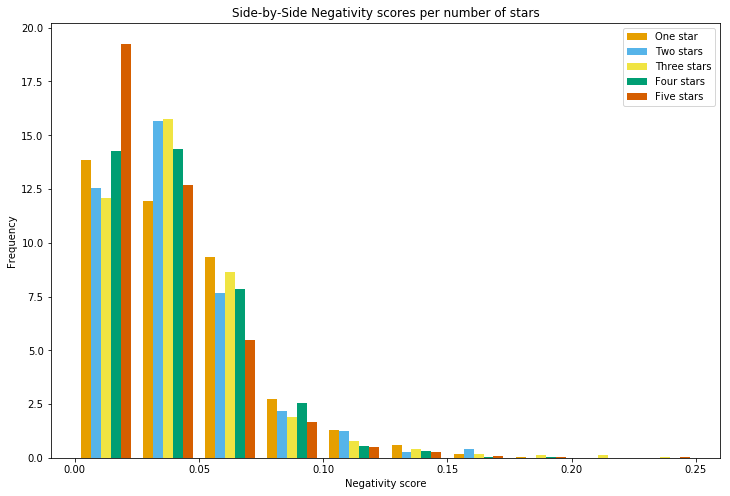

In [12]:
figsize(12,8)
#Assign colors to each score
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Negativity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Negativity scores per number of stars')
plt.show()

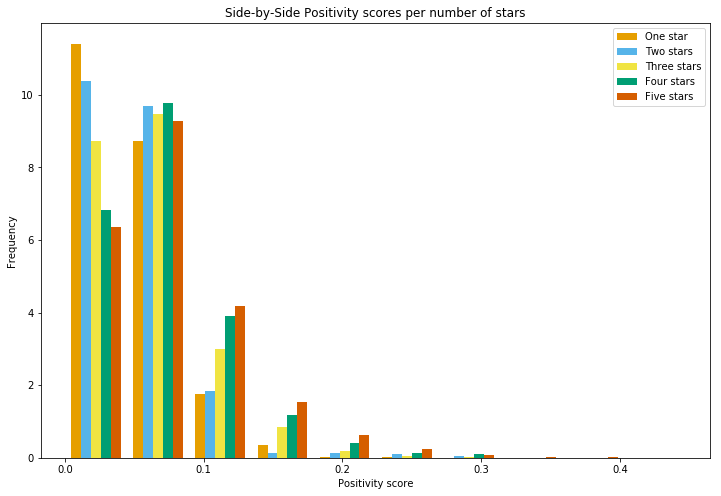

In [13]:

figsize(12,8)
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Positivity scores per number of stars')
plt.show()

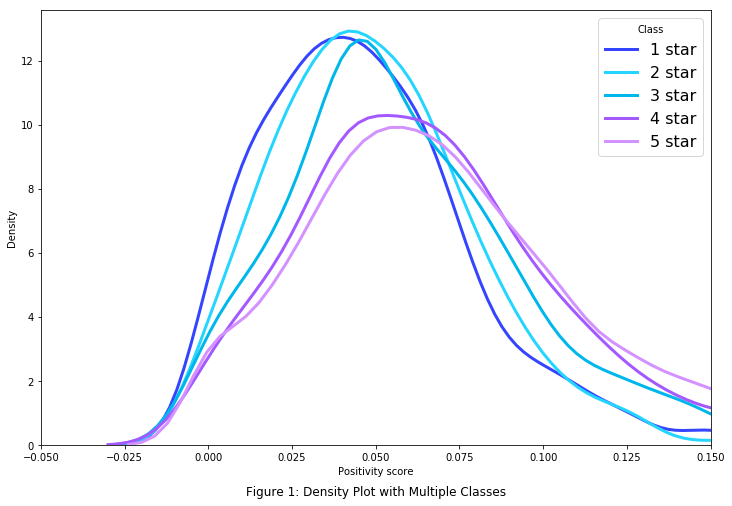

In [24]:
colorss = ['#3544ff', '#24d6ff', '#00b7eb', '#a458ff', '#d392ff']
pos_list = [one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos]
fig, ax = plt.subplots()
for pos in pos_list:
    sns.distplot(pos, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = str(pos_list.index(pos)+1)+' star',
                 color=colorss[pos_list.index(pos)])
ax.set_xlim(-0.05,0.15)

    
plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Figure 1: Density Plot with Multiple Classes', y=-0.13); 
plt.xlabel('Positivity score')
plt.ylabel('Density');
plt.show()

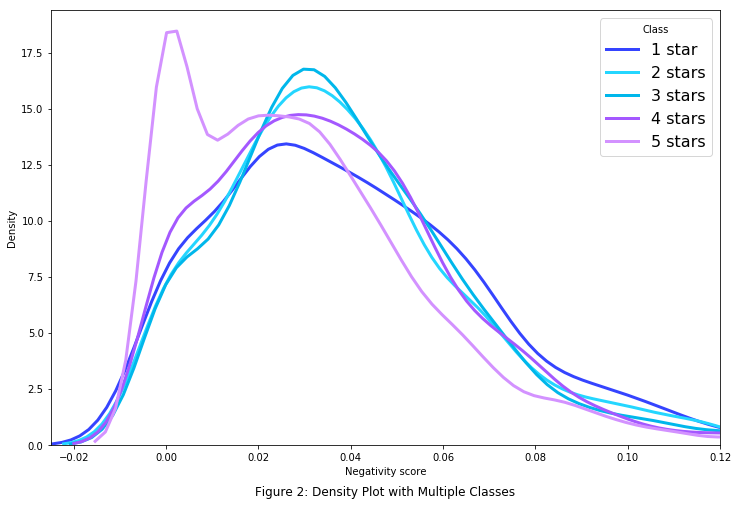

In [25]:
neg_list = [one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg]
fig, ax = plt.subplots()


def labels(index):
    num = index + 1
    if num > 1:
        return str(num) + ' stars'
    else: 
        return '1 star'

for neg in neg_list:
    sns.distplot(neg, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = labels(neg_list.index(neg)),
                color=colorss[neg_list.index(neg)])

ax.set_xlim(-0.025,0.12)


plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Figure 2: Density Plot with Multiple Classes', y =-0.13)
plt.xlabel('Negativity score')
plt.ylabel('Density')
plt.show()

# Finding Co-occurring Adjectives and Nouns to Find Important Aspects of Products #

We hypothesized that if we look at adjectives that co-occur with nouns and then compare the SentiWordNet polarities of those adjectives, we could find out exactly what it is about a product that consumers liked or didn't like (an example of this would be "great flavor" in a five star review or "terrible packaging" in a one star review.

In [16]:
with open('cooccs_final_list.txt', 'rb') as file:
    cooccs_list = pickle.load(file)
    
print(cooccs_list[:10])

[['B000TRFGGM', 5, ['love-NOUN', 'little-ADJ', 'venus-NOUN', 'produce-VERB', 'new-ADJ', 'arrive-VERB', 'quickly-ADV', 'good-ADJ', 'positive-ADJ']], ['B001LG945O', 4, ['admit-NOUN', 'care-NOUN', 'drink-NOUN', 'carbonate-VERB', 'carbonation-NOUN', 'soda-NOUN', 'make-VERB', 'tend-NOUN', 'diet-NOUN', 'drink-NOUN', 'weird-NOUN', 'taste-NOUN', 'sure-NOUN', 'expect-VERB', 'drank-NOUN', 'carbonation-NOUN', 'mild-NOUN', 'like-ADP', 'light-NOUN', 'buzz-NOUN', 'mouth-NOUN', 'instead-ADV', 'lot-NOUN', 'carbonation-NOUN', 'hear-NOUN', 'content-NOUN', 'fizz-NOUN', 'drink-NOUN', 'orange-NOUN', 'tangerine-NOUN', 'flavor-NOUN', 'nice-ADJ', 'combo-NOUN', 'strong-ADJ', 'tangerine-NOUN', 'flavor-NOUN', 'though-ADP', 'someone-NOUN', 'like-ADP', 'sugar-NOUN', 'found-NOUN', 'tad-NOUN', 'sweet-NOUN', 'advertised-ADJ', 'no-NEGATION', 'no-NEGATION', 'sugar-NOUN', 'less-ADV', 'not-NEGATION', 'not-NEGATION', 'sure-NOUN', 'would-VERB', 'drink-NOUN', 'though-ADP', 'small-ADJ', 'imagine-NOUN', 'someone-NOUN', 'drink

In [17]:
def analyze_review(lst):
    span = 2
    impt_features = []
    for i,w in enumerate(lst):
        w1, w2 = w.split("-") 
        if w2 != 'NOUN':
            continue   
         #check all co-occurring words within a 3 word span 
        span_range = list(range(max(i- span, 0), i)) 
        span_range.extend(range(i+1, min(i + span + 1, len(lst))))
        for cw in [lst[idx] for idx in span_range]:
            cw1, cw2 = cw.split("-")
            if cw2 in mapping:
                #get the right part of speech from predefined mapping
                new_pos = mapping[cw2]
                if len(list(swn.senti_synsets(cw1, pos = new_pos))) > 0 and cw2 == "ADJ":
                    scores = swn.senti_synset(cw1 + "."+ new_pos + ".01")
                    #make polarity the sum of positivity and negativity
                    positive = scores.pos_score()
                    negative = scores.neg_score()
                    polarity = positive + negative
                    #store co-occuring words with associated polarity in dict 
                    impt_features.append([polarity, cw, w1+"-"+w2])
                else:
                    impt_features.append([0, cw, w1+"-"+w2])
    #find the co-occurring words with the highest combined polarity score 
    max_polarity, tupl = 0, ()
    #check to see if this is a higher polarity example than the previous example
    for polarity, word1, word2 in impt_features:
        if polarity > max_polarity:
            max_polarity = polarity
            tupl = (word1, word2)
    return tupl 

In [18]:
impt_features = []
#this was the largest slice I could take without exceeding the data rate
cooccs_slice = cooccs_list[:20000]


#find important features about each product
for index, item in enumerate(cooccs_slice):
    prod_id = str(item[0])
    score = item[1]
    rev = item[2]
    impt_features.append([prod_id, score, analyze_review(rev)])
#print an example of the data    
print(impt_features[:2])

[['B000TRFGGM', 5, ('little-ADJ', 'love-NOUN')], ['B001LG945O', 4, ('nice-ADJ', 'tangerine-NOUN')]]


In [19]:
#print some examples to check for desired output
for i in range(15):
    if(impt_features[i][2] == ()):
        break
    prod = impt_features[i][0]
    score = impt_features[i][1]
    aspects = impt_features[i][2]
    
    print("The most important aspect of product " + str(prod) + " with score " + str(score) + " is " + str(aspects))

The most important aspect of product B000TRFGGM with score 5 is ('little-ADJ', 'love-NOUN')
The most important aspect of product B001LG945O with score 4 is ('nice-ADJ', 'tangerine-NOUN')
The most important aspect of product B000HDMUQ2 with score 2 is ('miserable-ADJ', 'texture-NOUN')
The most important aspect of product B006N3IG4K with score 5 is ('happy-ADJ', 'price-NOUN')
The most important aspect of product B00653KJ5M with score 4 is ('good-ADJ', 'one-NOUN')
The most important aspect of product B003VXL14M with score 5 is ('various-ADJ', 'ten-NOUN')


I thought it would be interesting to see what the most common compliments are - most of them ended up being fairly generic ("good taste", "good coffee", etc). This shows me that a. Amazon reviews are tricky to use for classification since often people revert to simplistic language or comments, and b. If I had more time to work on the project, I should refine my criteria for co-occurrences to focus on ones that are more unique and informative.

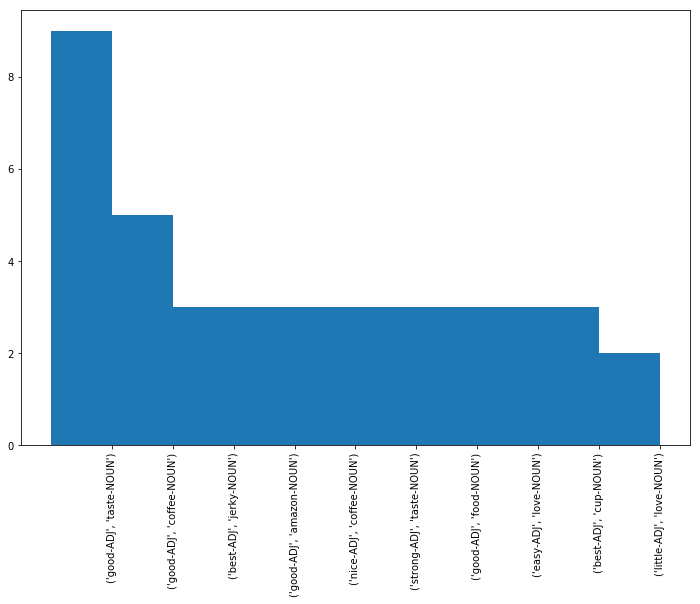

In [20]:
#plot the most common complaints or compliments overall 
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt

aspects = []

for i in range(len(impt_features)):
    if (impt_features[i][2] != ()):
        aspects.append(impt_features[i][2])
    
#counter variable to find most common tuple 
labels, values = zip(*Counter(aspects).most_common(10))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.xticks(rotation=90)
plt.show()